In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [50]:
df = pd.read_csv('../Train-dataset.csv')
df

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_NAME,LITH_CODE
0,Well-1,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,Marine,Marly sandstone,1200
1,Well-1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,Marine,Marly sandstone,1200
2,Well-1,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,Marine,Marly sandstone,1200
3,Well-1,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,Marine,Sandy marl,1300
4,Well-1,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,Marine,Sandy marl,1300
...,...,...,...,...,...,...,...,...,...,...,...
45744,Well-10,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,Marine,Clay marl,400
45745,Well-10,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,Marine,Clay marl,400
45746,Well-10,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,Marine,Clay marl,400
45747,Well-10,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,Marine,Clay marl,400


In [51]:
df = df.drop(['WELL', 'LITH_NAME'], axis=1)
df

,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_CODE
0,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,Marine,1200
1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,Marine,1200
2,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,Marine,1200
3,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,Marine,1300
4,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,Marine,1300
...,...,...,...,...,...,...,...,...,...
45744,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,Marine,400
45745,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,Marine,400
45746,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,Marine,400
45747,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,Marine,400


In [52]:
ohe = OneHotEncoder(sparse=False)
new_ohe_features = ohe.fit_transform(df.DEPOSITIONAL_ENVIRONMENT.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['ENV' + 
                                             str(i) for i in range(new_ohe_features.shape[1])])
df = pd.concat([df, tmp], axis=1)
df = df.drop(['DEPOSITIONAL_ENVIRONMENT'], axis=1)
cols = df.columns.tolist()
cols = cols[0:7] + cols[8:11] + cols[7:8]
df = df[cols]
df

,X,Y,MD,GR,RT,CN,DEN,ENV0,ENV1,ENV2,LITH_CODE
0,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,0.0,1.0,0.0,1200
1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,0.0,1.0,0.0,1200
2,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,0.0,1.0,0.0,1200
3,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,0.0,1.0,0.0,1300
4,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,0.0,1.0,0.0,1300
...,...,...,...,...,...,...,...,...,...,...,...
45744,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,0.0,1.0,0.0,400
45745,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,0.0,1.0,0.0,400
45746,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,0.0,1.0,0.0,400
45747,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,0.0,1.0,0.0,400


<AxesSubplot:xlabel='LITH_CODE', ylabel='count'>

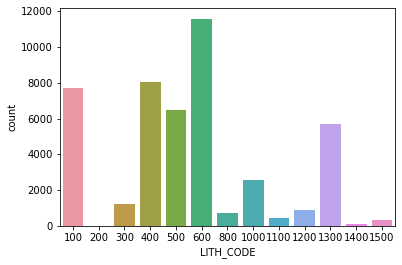

In [53]:
sns.countplot(x = 'LITH_CODE', data=df)

In [54]:
class2idx = {
    100:0,
    200:1,
    300:2,
    400:3,
    500:4,
    600:5,
    800:6,
    1000:7,
    1100:8,
    1200:9,
    1300:10,
    1400:11,
    1500:12
}

idx2class = {v: k for k, v in class2idx.items()}
df['LITH_CODE'].replace(class2idx, inplace=True)
df

,X,Y,MD,GR,RT,CN,DEN,ENV0,ENV1,ENV2,LITH_CODE
0,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,0.0,1.0,0.0,9
1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,0.0,1.0,0.0,9
2,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,0.0,1.0,0.0,9
3,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,0.0,1.0,0.0,10
4,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,0.0,1.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...
45744,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,0.0,1.0,0.0,3
45745,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,0.0,1.0,0.0,3
45746,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,0.0,1.0,0.0,3
45747,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,0.0,1.0,0.0,3


In [55]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [56]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [57]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Text(0.5, 1.0, 'Class Distribution in Test Set')

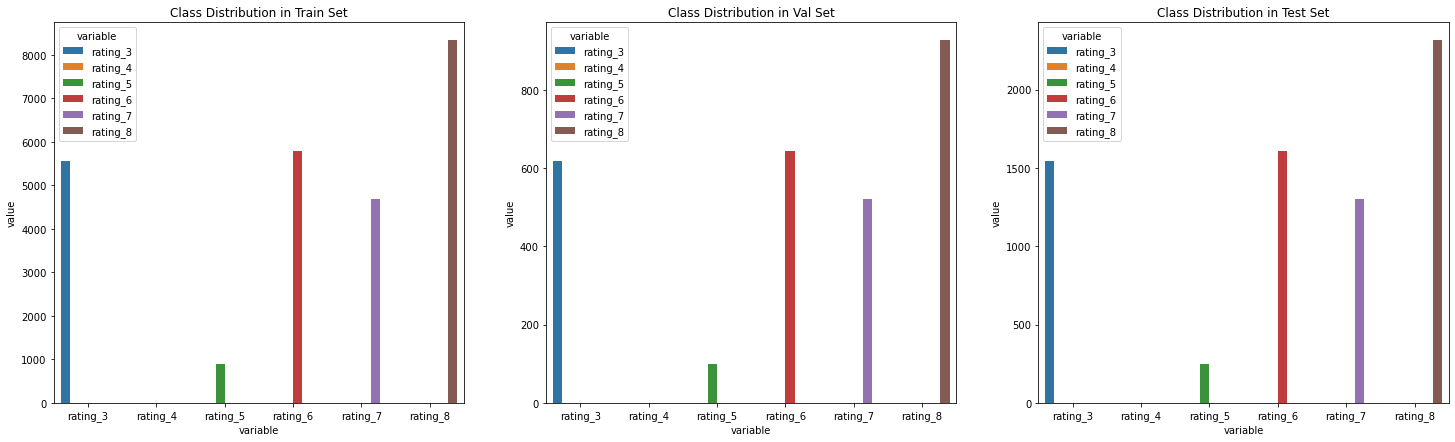

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


In [59]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [60]:
train_dataset

In [61]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [62]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check classes.
Check clas

tensor([1.7999e-04, 5.0000e-01, 1.1236e-03, 1.7244e-04, 2.1381e-04, 1.2002e-04])

In [74]:

EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 13

In [75]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [76]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [78]:
model1 = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

In [79]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()

In [80]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [81]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [82]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model1(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model1.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model1(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.07592 | Val Loss: 0.77100 | Train Acc: 63.879| Val Acc: 74.699
Epoch 002: | Train Loss: 0.91203 | Val Loss: 0.72025 | Train Acc: 67.966| Val Acc: 76.585
Epoch 003: | Train Loss: 0.87100 | Val Loss: 0.69979 | Train Acc: 69.119| Val Acc: 76.175
Epoch 004: | Train Loss: 0.84554 | Val Loss: 0.68447 | Train Acc: 69.832| Val Acc: 77.131
Epoch 005: | Train Loss: 0.82514 | Val Loss: 0.66997 | Train Acc: 70.315| Val Acc: 77.268
Epoch 006: | Train Loss: 0.80923 | Val Loss: 0.65784 | Train Acc: 70.982| Val Acc: 77.705
Epoch 007: | Train Loss: 0.79337 | Val Loss: 0.64052 | Train Acc: 71.270| Val Acc: 78.661
Epoch 008: | Train Loss: 0.78246 | Val Loss: 0.63842 | Train Acc: 71.742| Val Acc: 77.814
Epoch 009: | Train Loss: 0.77166 | Val Loss: 0.62981 | Train Acc: 71.890| Val Acc: 78.661
Epoch 010: | Train Loss: 0.76269 | Val Loss: 0.61851 | Train Acc: 72.129| Val Acc: 78.443
Epoch 011: | Train Loss: 0.75634 | Val Loss: 0.62850 | Train Acc: 72.652| Val Acc: 77.978
Epoch 012:

Epoch 093: | Train Loss: 0.50112 | Val Loss: 0.57544 | Train Acc: 80.786| Val Acc: 80.055
Epoch 094: | Train Loss: 0.49606 | Val Loss: 0.57269 | Train Acc: 80.899| Val Acc: 79.809
Epoch 095: | Train Loss: 0.49654 | Val Loss: 0.56965 | Train Acc: 81.015| Val Acc: 80.055
Epoch 096: | Train Loss: 0.49559 | Val Loss: 0.56851 | Train Acc: 81.076| Val Acc: 80.000
Epoch 097: | Train Loss: 0.49081 | Val Loss: 0.57501 | Train Acc: 81.363| Val Acc: 79.781
Epoch 098: | Train Loss: 0.49041 | Val Loss: 0.57031 | Train Acc: 81.254| Val Acc: 79.809
Epoch 099: | Train Loss: 0.48992 | Val Loss: 0.56685 | Train Acc: 81.138| Val Acc: 80.710
Epoch 100: | Train Loss: 0.49068 | Val Loss: 0.57641 | Train Acc: 81.408| Val Acc: 79.781


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

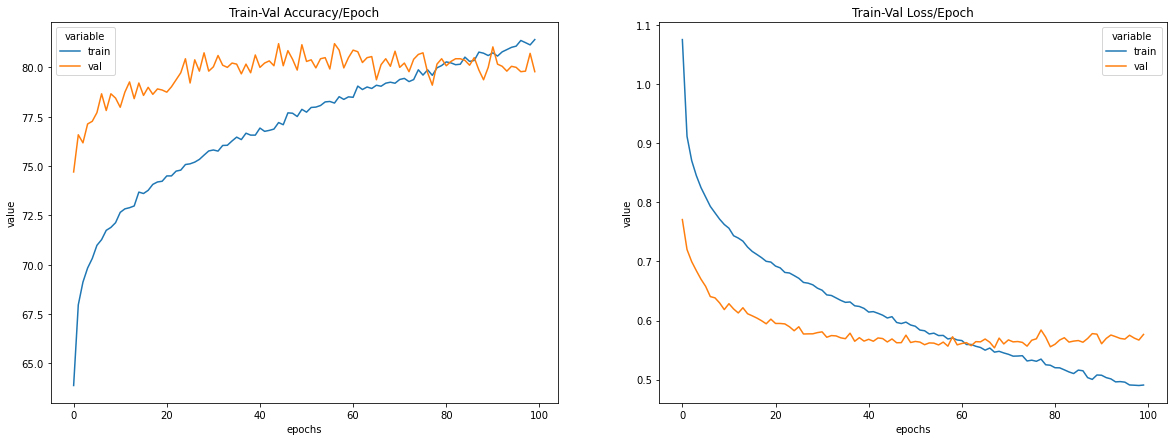

In [83]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [84]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [85]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1543
           1       0.00      0.00      0.00         1
           2       0.59      0.30      0.39       247
           3       0.78      0.92      0.85      1611
           4       0.78      0.84      0.81      1299
           5       0.88      0.90      0.89      2314
           6       0.84      0.68      0.75       139
           7       0.73      0.76      0.74       509
           8       0.49      0.39      0.43        89
           9       0.45      0.21      0.29       178
          10       0.67      0.58      0.62      1135
          11       0.88      0.41      0.56        17
          12       0.48      0.47      0.47        68

    accuracy                           0.79      9150
   macro avg       0.65      0.56      0.59      9150
weighted avg       0.78      0.79      0.78      9150



/home/alexander/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
validation_dataset = pd.read_csv('../Validation-dataset.csv')
validation_dataset = validation_dataset.drop(['WELL'], axis=1)

ohe = OneHotEncoder(sparse=False)
new_ohe_features = ohe.fit_transform(validation_dataset.DEPOSITIONAL_ENVIRONMENT.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['ENV' + 
                                             str(i) for i in range(new_ohe_features.shape[1])])
validation_dataset = pd.concat([validation_dataset, tmp], axis=1)
validation_dataset = validation_dataset.drop(['DEPOSITIONAL_ENVIRONMENT'], axis=1)
validation_dataset

,X,Y,MD,GR,RT,CN,DEN,ENV0,ENV1,ENV2
0,2.9956,0.0061,897.065,92.7094,4.51768,0.36366,2.2106,1.0,0.0,0.0
1,2.9956,0.0061,897.165,93.9007,4.30683,0.36951,2.2036,1.0,0.0,0.0
2,2.9956,0.0061,897.265,94.8446,3.98902,0.37914,2.1969,1.0,0.0,0.0
3,2.9956,0.0061,897.365,95.6321,3.67028,0.39020,2.1923,1.0,0.0,0.0
4,2.9956,0.0061,897.465,96.4700,3.63431,0.40098,2.1926,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
28992,1.1475,2.6893,1717.800,108.7532,2.18830,0.31751,2.4094,0.0,1.0,0.0
28993,1.1475,2.6893,1717.900,108.0650,2.21620,0.31582,2.4125,0.0,1.0,0.0
28994,1.1475,2.6893,1718.000,108.0439,2.25220,0.31304,2.4150,0.0,1.0,0.0
28995,1.1475,2.6893,1718.100,108.6799,2.30580,0.30963,2.4175,0.0,1.0,0.0
